In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import scipy.optimize as opt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import gc

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import os

import scipy as sp

# _FOLDER = "/home/ac1jjgg/MOGP_GPyTorch/FiveCancersDataSet/"
_FOLDER = "/home/juanjo/Work_Postdoc/my_codes_postdoc/GPyTorch_Models/FiveCancersDataSet/"

In [2]:
def sigmoid_4_param(x, x0, L, k, d):
    """ Comparing with Dennis Wang's sigmoid:
    x0 -  p - position, correlation with IC50 or EC50
    L = 1 in Dennis Wang's sigmoid, protect from devision by zero if x is too small 
    k = -1/s (s -shape parameter)
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then Dennis Wang's sigmoid

    """
    return ( 1/ (L + np.exp(-k*(x-x0))) + d)

Train Name in Nfold 0: Breast_train_GMLcLa_updated.csv
Test Name in Nfold 0: Breast_test_updated.csv
854
ACACA_mut
Columns with std equal zero:
(array([], dtype=int64),)
(2966, 1)
Ytrain size:  (2966, 9)
Ytest size:  (663, 9)
0.4958622057145847
0.750305859518037
AUC train size: (2966, 1)
AUC test size: (663, 1)
IC50 train size: (2966, 1)
IC50 test size: (663, 1)
Emax train size: (2966, 1)
Emax test size: (663, 1)
X train size: (2966, 825)
X test size: (663, 825)
Y train size: (2966, 9)
Y test size: (663, 9)
Train Name in Nfold 1: Glioma_train_BMLcLa_updated.csv
Test Name in Nfold 1: Glioma_test_updated.csv
854
ACACA_mut
Columns with std equal zero:
(array([], dtype=int64),)
(2970, 1)
Ytrain size:  (2970, 9)
Ytest size:  (659, 9)
0.750305859518037
0.4958622057145847
AUC train size: (2970, 1)
AUC test size: (659, 1)
IC50 train size: (2970, 1)
IC50 test size: (659, 1)
Emax train size: (2970, 1)
Emax test size: (659, 1)
X train size: (2970, 825)
X test size: (659, 825)
Y train size: (2970,

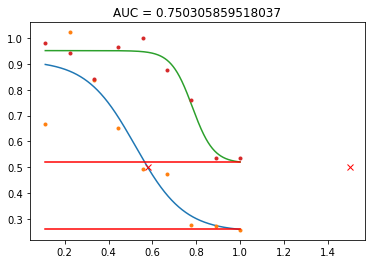

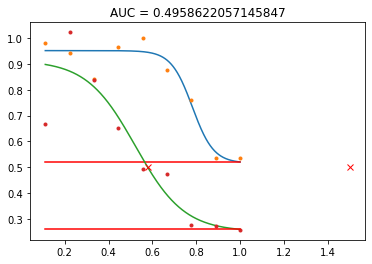

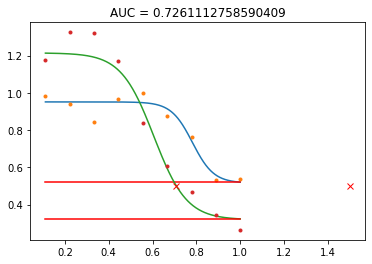

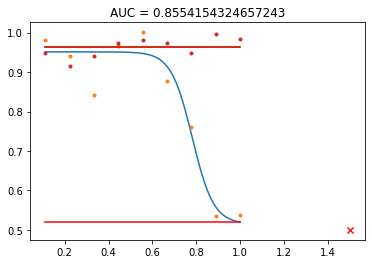

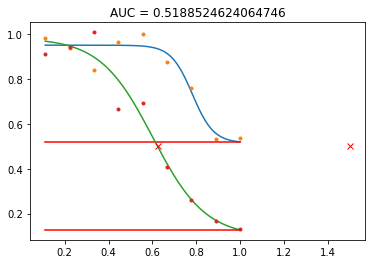

In [3]:
Train_names = ['Breast_train_GMLcLa_updated.csv', 'Glioma_train_BMLcLa_updated.csv',
               'LungAdenocarcinoma_train_BGMLc_updated.csv', 'LungCarcinoma_train_BGMLa_updated.csv',
               'Melanoma_train_BGLcLa_updated.csv']
Test_names = ['Breast_test_updated.csv', 'Glioma_test_updated.csv', 'Lung_adenocarcinoma_test_updated.csv',
              'Lung_carcinoma_test_updated.csv', 'Melanoma_test_updated.csv']

Train_5folds_X = []
Val_5folds_X = []
Train_5folds_Y = []
Val_5folds_Y = []
Train_5folds_AUC = []
Val_5folds_AUC = []
Train_5folds_IC50 = []
Val_5folds_IC50 = []
Train_5folds_Emax = []
Val_5folds_Emax = []

for Nfold in range(0, 5):
    print(f"Train Name in Nfold {Nfold}:", Train_names[Nfold])
    print(f"Test Name in Nfold {Nfold}:", Test_names[Nfold])
    df_train_No_MolecForm = pd.read_csv(
        _FOLDER + "Train/" + Train_names[Nfold])  # Contain Train dataset prepared by Subhashini-Evelyn
    df_test_No_MolecForm = pd.read_csv(
        _FOLDER + "/Test/" + Test_names[Nfold])  # Contain Test dataset prepared by Subhashini-Evelyn

    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    # we realised that the column "molecular_formula" is a string like
    # The updated files by subhashini do not have 'molecular_formula' anymore
    # df_train_No_MolecForm = df_train.drop(columns='molecular_formula')
    # df_test_No_MolecForm = df_test.drop(columns='molecular_formula')
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    try:
        df_train_No_MolecForm = df_train_No_MolecForm.drop(columns='Drug_Name')
    except:
        pass

    try:
        df_test_No_MolecForm = df_test_No_MolecForm.drop(columns='Drug_Name')
    except:
        pass

    ##df_train_No_MolecForm
    ##df_test_No_MolecForm
    ##Checking if both train and test have the same names for their columns
    print((df_train_No_MolecForm.columns == df_test_No_MolecForm.columns).sum())
    # Here we just check that from the column index 29 the input features start
    print(df_train_No_MolecForm.columns[29])

    All_data_together = pd.concat([df_train_No_MolecForm[df_train_No_MolecForm.columns[29:]],
                                   df_test_No_MolecForm[df_test_No_MolecForm.columns[29:]]])
    print("Columns with std equal zero:")
    print(np.where(All_data_together.std(0) == 0.0))

    # df_train_values = df_train_No_MolecForm[df_train_No_MolecForm.columns[29:]].values
    # df_test_values = df_test_No_MolecForm[df_test_No_MolecForm.columns[29:]].values
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    # X_train_features = df_train_No_MolecForm[df_train_No_MolecForm.columns[29:]].values
    # X_test_features = df_test_No_MolecForm[df_test_No_MolecForm.columns[29:]].values

    scaler = MinMaxScaler().fit(df_train_No_MolecForm[df_train_No_MolecForm.columns[29:]])
    X_train_features = scaler.transform(df_train_No_MolecForm[df_train_No_MolecForm.columns[29:]])
    X_test_features = scaler.transform(df_test_No_MolecForm[df_test_No_MolecForm.columns[29:]])

    y_train_drug = np.clip(df_train_No_MolecForm["norm_cells_" + str(1)].values[:, None], 1.0e-9, np.inf)
    y_test_drug = np.clip(df_test_No_MolecForm["norm_cells_" + str(1)].values[:, None], 1.0e-9, np.inf)
    print(y_train_drug.shape)
    for i in range(2, 10):
        y_train_drug = np.concatenate(
            (y_train_drug, np.clip(df_train_No_MolecForm["norm_cells_" + str(i)].values[:, None], 1.0e-9, np.inf)), 1)
        y_test_drug = np.concatenate(
            (y_test_drug, np.clip(df_test_No_MolecForm["norm_cells_" + str(i)].values[:, None], 1.0e-9, np.inf)), 1)

    print("Ytrain size: ", y_train_drug.shape)
    print("Ytest size: ", y_test_drug.shape)

    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    params_4_sig_train = df_train_No_MolecForm["param_" + str(1)].values[:, None]
    params_4_sig_test = df_test_No_MolecForm["param_" + str(1)].values[:, None]
    for i in range(2, 5):
        params_4_sig_train = np.concatenate(
            (params_4_sig_train, df_train_No_MolecForm["param_" + str(i)].values[:, None]), 1)
        params_4_sig_test = np.concatenate((params_4_sig_test, df_test_No_MolecForm["param_" + str(i)].values[:, None]),
                                           1)

    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    import matplotlib.pyplot as plt
    from sklearn import metrics

    x_lin = np.linspace(0.111111, 1, 1000)
    x_real_dose = np.linspace(0.111111, 1, 9)
    x_lin_tile = np.tile(x_lin, (params_4_sig_train.shape[0], 1))
    # (x_lin,params_4_sig_train.shape[0],1).shape
    Ydose_res = []
    AUC = []
    IC50 = []
    Ydose50 = []
    Emax = []
    for i in range(params_4_sig_train.shape[0]):
        Ydose_res.append(sigmoid_4_param(x_lin_tile[i, :], *params_4_sig_train[i, :]))
        AUC.append(metrics.auc(x_lin_tile[i, :], Ydose_res[i]))
        Emax.append(Ydose_res[i][-1])
        res1 = (Ydose_res[i] < 0.507)
        res2 = (Ydose_res[i] > 0.493)
        if (res1 & res2).sum() > 0:
            Ydose50.append(Ydose_res[i][res1 & res2].mean())
            IC50.append(x_lin[res1 & res2].mean())
        else:
            Ydose50.append(0.5)
            IC50.append(1.5) #IC50.append(x_lin[-1])

    posy = 90
    plt.figure(Nfold)
    plt.plot(x_lin, Ydose_res[posy])
    plt.plot(x_real_dose, y_train_drug[posy, :], '.')
    plt.plot(IC50[posy], Ydose50[posy], 'rx')
    plt.plot(x_lin, np.ones_like(x_lin)*Emax[posy], 'r') #Plot a horizontal line as Emax
    plt.title(f"AUC = {AUC[posy]}")
    print(AUC[posy])
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    import matplotlib.pyplot as plt
    from sklearn import metrics

    x_lin = np.linspace(0.111111, 1, 1000)
    x_real_dose = np.linspace(0.111111, 1, 9)
    x_lin_tile = np.tile(x_lin, (params_4_sig_test.shape[0], 1))
    # (x_lin,params_4_sig_train.shape[0],1).shape
    Ydose_res_test = []
    AUC_test = []
    IC50_test = []
    Ydose50_test = []
    Emax_test = []
    for i in range(params_4_sig_test.shape[0]):
        Ydose_res_test.append(sigmoid_4_param(x_lin_tile[i, :], *params_4_sig_test[i, :]))
        AUC_test.append(metrics.auc(x_lin_tile[i, :], Ydose_res_test[i]))
        Emax_test.append(Ydose_res_test[i][-1])
        res1 = (Ydose_res_test[i] < 0.507)
        res2 = (Ydose_res_test[i] > 0.493)
        if (res1 & res2).sum() > 0:
            Ydose50_test.append(Ydose_res_test[i][res1 & res2].mean())
            IC50_test.append(x_lin[res1 & res2].mean())
        else:
            Ydose50_test.append(0.5)
            IC50_test.append(1.5) #IC50_test.append(x_lin[-1])

    posy = 90
    plt.figure(Nfold)
    plt.plot(x_lin, Ydose_res_test[posy])
    plt.plot(x_real_dose, y_test_drug[posy, :], '.')
    plt.plot(x_lin, np.ones_like(x_lin) * Emax_test[posy], 'r')  #Plot a horizontal line as Emax
    plt.plot(IC50_test[posy], Ydose50_test[posy], 'rx')
    plt.title(f"AUC = {AUC_test[posy]}")
    print(AUC_test[posy])
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    # Compute Log(AUC)? R/ Not for Functional Random Forest Model
    # AUC = np.log(np.array(AUC))
    AUC = np.array(AUC)
    AUC_test = np.array(AUC_test)[:, None].copy()

    #Ydose50_all = np.array(Ydose50_all)
    IC50 = np.array(IC50)
    IC50_test = np.array(IC50_test)[:,None].copy()

    Emax = np.array(Emax)
    Emax_test = np.array(Emax_test)[:, None].copy()

    Xall = X_train_features.copy()
    Xtest = X_test_features.copy()

    Yall = y_train_drug.copy()
    Ytest = y_test_drug.copy()

    AUC_all = AUC[:, None].copy()
    IC50_all = IC50[:, None].copy()
    Emax_all = Emax[:, None].copy()

    print("AUC train size:", AUC_all.shape)
    print("AUC test size:", AUC_test.shape)
    print("IC50 train size:", IC50_all.shape)
    print("IC50 test size:", IC50_test.shape)
    print("Emax train size:", Emax_all.shape)
    print("Emax test size:", Emax_test.shape)
    print("X train size:", Xall.shape)
    print("X test size:", Xtest.shape)
    print("Y train size:", Yall.shape)
    print("Y test size:", Ytest.shape)

    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Val_5folds_X.append(Xtest.copy())
    Train_5folds_X.append(Xall.copy())
    Val_5folds_Y.append(Ytest.copy())
    Train_5folds_Y.append(Yall.copy())
    Val_5folds_AUC.append(AUC_test.copy())
    Train_5folds_AUC.append(AUC_all.copy())
    Val_5folds_IC50.append(IC50_test.copy())
    Train_5folds_IC50.append(IC50_all.copy())
    Val_5folds_Emax.append(Emax_test.copy())
    Train_5folds_Emax.append(Emax_all.copy())

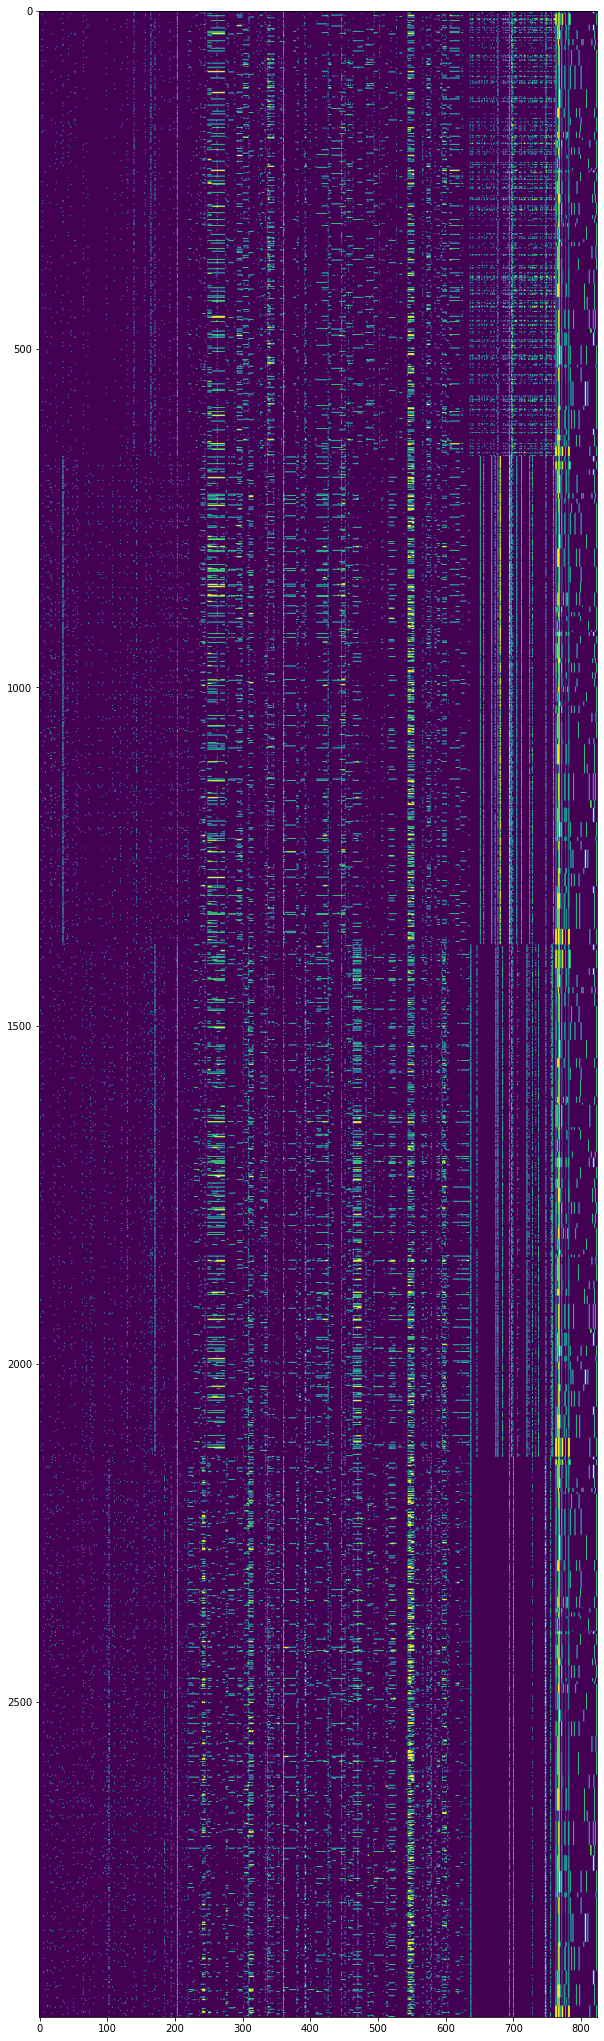

In [4]:
plt.figure(6,figsize=(10,60))
plt.imshow(Train_5folds_X[0])

#Train_5folds_X[0]
#Check_zeros = Train_5folds_X[0]==0.0
#total_zeros = np.sum(Check_zeros,0)
#plt.hist(total_zeros,bins = 400)

#np.max(Train_5folds_X[0],0)

In [5]:
path_to_save = "/home/juanjo/Work_Postdoc/Bench_Mark_DrugResponse_Models/Functional-Random-forest-master/FiveCancersDataSet/"

for i in range(5):
    np.savetxt(path_to_save+"X_Train_fold"+str(i+1)+".csv", Train_5folds_X[i], delimiter=",")
    np.savetxt(path_to_save+"Y_Train_fold"+str(i+1)+".csv", Train_5folds_Y[i], delimiter=",")
    np.savetxt(path_to_save+"X_Val_fold"+str(i+1)+".csv", Val_5folds_X[i], delimiter=",")
    np.savetxt(path_to_save+"Y_Val_fold"+str(i+1)+".csv", Val_5folds_Y[i], delimiter=",")
    np.savetxt(path_to_save+"AUC_Train_fold"+str(i+1)+".csv", Train_5folds_AUC[i], delimiter=",")
    np.savetxt(path_to_save+"AUC_Val_fold"+str(i+1)+".csv", Val_5folds_AUC[i], delimiter=",")
    
    np.savetxt(path_to_save+"IC50_Train_fold"+str(i+1)+".csv", Train_5folds_IC50[i], delimiter=",")
    np.savetxt(path_to_save+"IC50_Val_fold"+str(i+1)+".csv", Val_5folds_IC50[i], delimiter=",")
    
    np.savetxt(path_to_save+"Emax_Train_fold"+str(i+1)+".csv", Train_5folds_Emax[i], delimiter=",")
    np.savetxt(path_to_save+"Emax_Val_fold"+str(i+1)+".csv", Val_5folds_Emax[i], delimiter=",")
    

In [31]:
X_columns_CosmicID_DrugID = ["COSMIC_ID","DRUG_ID"]+ X_columns
df_train_X = df_train_drug_new[X_columns_CosmicID_DrugID]
df_group_train_X_cells = df_train_X.drop_duplicates(subset ="COSMIC_ID")
df_group_train_X_cells

,COSMIC_ID,DRUG_ID,MAX_CONC,molecular_weight,2bonds,3bonds,xlogp,formal_charge,surface_area,complexity,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,687596,133,1.024,543.50,9.0,0.0,1.3,0.0,206.0,977.0,...,0,0,0,0,0,0,0,0,0,0
52,687600,5,8.000,398.50,8.0,0.0,2.6,0.0,77.2,636.0,...,0,0,0,0,0,0,0,0,0,0
95,687777,134,16.000,588.60,7.0,0.0,0.6,0.0,161.0,969.0,...,0,0,0,0,0,0,0,0,0,0
124,687780,133,1.024,543.50,9.0,0.0,1.3,0.0,206.0,977.0,...,0,0,0,0,0,0,0,0,0,0
183,687787,134,16.000,588.60,7.0,0.0,0.6,0.0,161.0,969.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8952,1330964,1006,2.000,243.22,3.0,0.0,-2.1,0.0,129.0,383.0,...,0,0,0,0,0,0,0,0,0,0
8967,1330972,3,0.100,914.20,9.0,0.0,6.0,0.0,195.0,1760.0,...,0,0,0,0,0,0,0,0,0,0
9025,1330973,1026,1.000,585.70,10.0,0.0,2.6,0.0,166.0,1210.0,...,0,0,0,0,0,0,0,0,0,0
9030,1503369,152,16.000,349.30,10.0,0.0,1.8,0.0,114.0,470.0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
X_columns_drugs = ["MAX_CONC"] + X_PubChem_properties +  X_targets + X_target_pathway
X_columns_cells = X_cancer_cell_lines

In [60]:
df_train_X_CellLines =  df_group_train_X_cells[X_columns_cells]
df_train_X_CellLines

,ABCB1_mut,ABL2_mut,ACACA_mut,ACVR1B_mut,ACVR2A_mut,ADCY1_mut,AFF4_mut,AHCTF1_mut,AHNAK_mut,AKAP9_mut,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
124,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
183,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8952,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


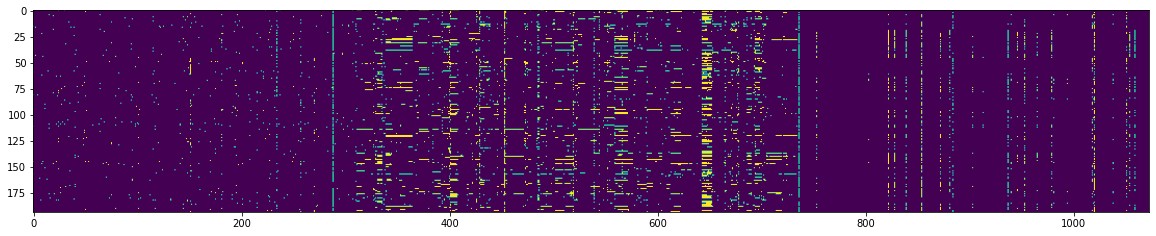

In [61]:
plt.figure(figsize=(20,40))
plt.imshow(df_train_X_CellLines)

In [62]:
X_columns_CosmicID_DrugID = ["COSMIC_ID","DRUG_ID"]+ X_columns
df_train_X = df_train_drug_new[X_columns_CosmicID_DrugID]
df_group_train_X_drugs = df_train_X.drop_duplicates(subset ="DRUG_ID")
df_group_train_X_drugs

,COSMIC_ID,DRUG_ID,MAX_CONC,molecular_weight,2bonds,3bonds,xlogp,formal_charge,surface_area,complexity,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,687596,133,1.024,543.50,9.0,0.0,1.3,0.0,206.0,977.0,...,0,0,0,0,0,0,0,0,0,0
1,687596,135,1.024,263.20,3.0,0.0,-1.5,0.0,108.0,426.0,...,0,0,0,0,0,0,0,0,0,0
2,687596,136,16.000,334.33,5.0,0.0,-0.4,0.0,147.0,757.0,...,0,0,0,0,0,0,0,0,0,0
3,687596,140,0.064,778.90,12.0,0.0,3.6,0.0,134.0,1690.0,...,0,0,0,0,0,0,0,0,0,0
4,687596,151,10.240,567.70,16.0,0.0,7.6,0.0,85.1,842.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,687997,306,10.240,524.70,11.0,0.0,4.8,0.0,117.0,787.0,...,0,0,0,0,0,0,0,0,0,0
1108,687997,1025,10.000,371.20,10.0,0.0,3.9,0.0,51.1,621.0,...,0,0,0,0,0,0,0,0,0,0
1380,688013,94,10.000,364.40,8.0,0.0,1.9,0.0,57.2,710.0,...,0,0,0,0,0,0,0,0,0,0
1423,688013,1061,5.000,453.50,12.0,0.0,2.1,0.0,78.3,1080.0,...,0,0,0,0,0,0,0,0,0,0


(194, 1073)

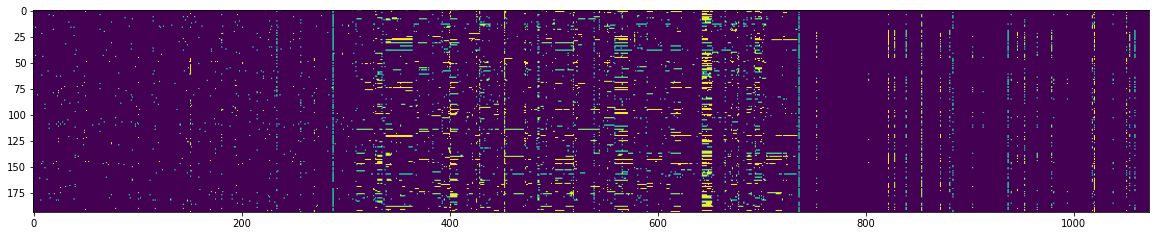

In [63]:
scaler_cells = MinMaxScaler().fit(df_train_X_CellLines)
X_cells_features = scaler_cells.transform(df_train_X_CellLines)
plt.figure(figsize=(20,40))
plt.imshow(X_cells_features)
X_cells_features.shape

In [64]:
Matrix_cells_corr = np.corrcoef(X_cells_features)
print(np.corrcoef(X_cells_features[0,:],X_cells_features[1,:]))

[[1.         0.37397485]
 [0.37397485 1.        ]]


In [65]:
np.savetxt(path_to_save+"Matrix_cells.csv", Matrix_cells_corr, delimiter=",")
Matrix_cells_corr

array([[1.        , 0.37397485, 0.1204981 , ..., 0.28290845, 0.26740543,
        0.01569487],
       [0.37397485, 1.        , 0.11356118, ..., 0.24161317, 0.37865103,
        0.3104968 ],
       [0.1204981 , 0.11356118, 1.        , ..., 0.14244564, 0.14988251,
        0.22996927],
       ...,
       [0.28290845, 0.24161317, 0.14244564, ..., 1.        , 0.09453401,
        0.13423473],
       [0.26740543, 0.37865103, 0.14988251, ..., 0.09453401, 1.        ,
        0.11962363],
       [0.01569487, 0.3104968 , 0.22996927, ..., 0.13423473, 0.11962363,
        1.        ]])

In [66]:
#df_group_train_X_drugs.sort_values("DRUG_ID")
#plt.plot(df_group_train_X_drugs["DRUG_ID"])
#plt.plot(df_group_train_X_drugs.sort_values("DRUG_ID"))
df_group_train_X_drugs_sorted = df_group_train_X_drugs.sort_values("DRUG_ID").reset_index()

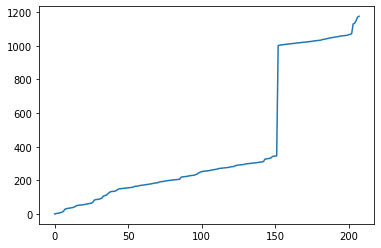

In [67]:
plt.plot(df_group_train_X_drugs_sorted["DRUG_ID"])

In [68]:
df_train_X_Drugs =  df_group_train_X_drugs_sorted[X_columns_drugs]
df_train_X_Drugs

,MAX_CONC,molecular_weight,2bonds,3bonds,xlogp,formal_charge,surface_area,complexity,h_bond_donor_count,h_bond_acceptor_count,...,DNA replication,Hormone-related,Genome integrity,WNT signaling,JNK and p38 signaling,Chromatin other,Metabolism,Apoptosis regulation,Chromatin histone methylation,p53 pathway
0,2.0,393.4,8.0,1.0,3.3,0.0,74.7,525.0,1.0,7.0,...,0,0,0,0,0,0,0,0,0,0
1,0.1,914.2,9.0,0.0,6.0,0.0,195.0,1760.0,3.0,13.0,...,0,0,0,0,0,0,0,0,0,0
2,8.0,398.5,8.0,0.0,2.6,0.0,77.2,636.0,3.0,4.0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,641.6,13.0,0.0,5.0,0.0,111.0,1180.0,2.0,5.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,475.6,7.0,0.0,4.8,0.0,114.0,644.0,3.0,5.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,10.0,390.4,7.0,0.0,3.2,0.0,60.9,510.0,1.0,8.0,...,0,0,0,0,0,0,0,0,0,0
204,10.0,328.4,10.0,0.0,4.6,0.0,52.7,387.0,3.0,3.0,...,0,0,0,0,0,0,0,0,0,1
205,5.0,573.7,15.0,0.0,7.8,0.0,132.0,963.0,4.0,6.0,...,0,0,0,0,0,0,0,1,0,0
206,10.0,352.4,8.0,0.0,3.7,0.0,87.6,479.0,3.0,5.0,...,0,0,0,0,0,0,0,0,0,0


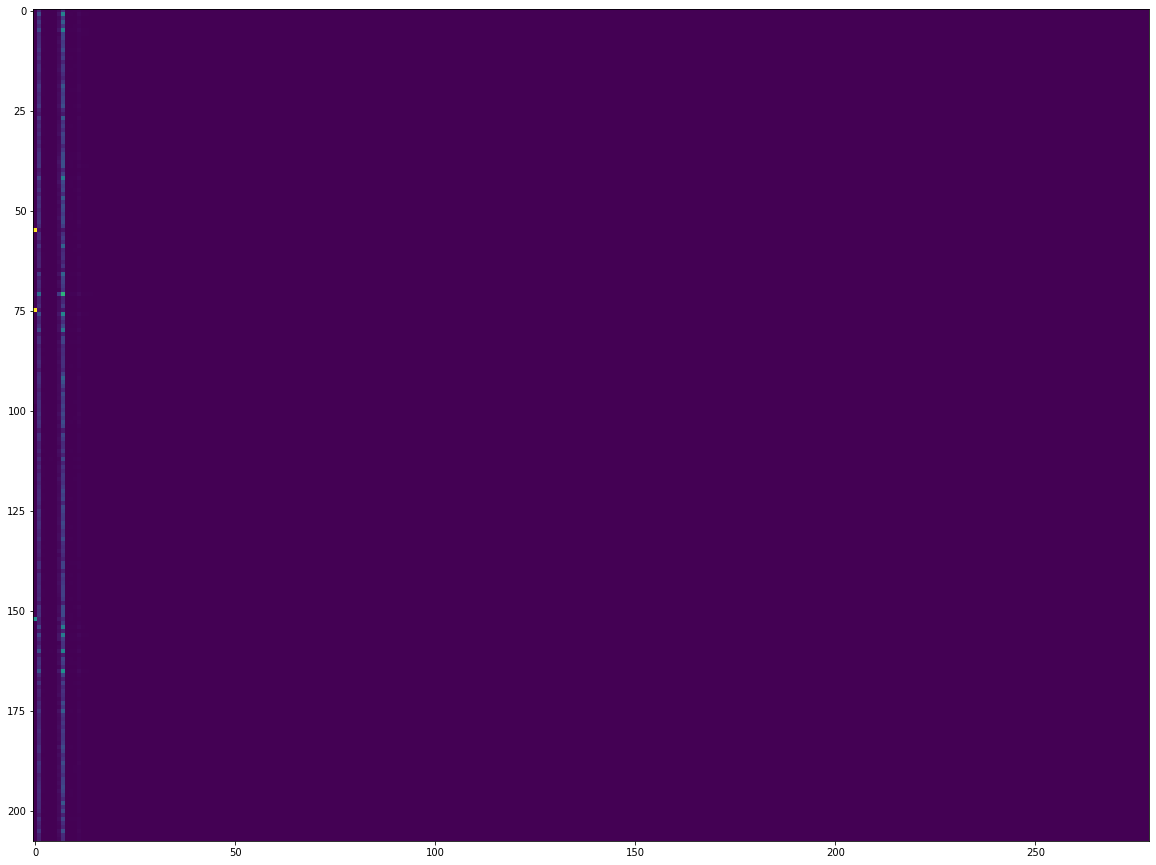

In [69]:
plt.figure(figsize=(20,40))
plt.imshow(df_train_X_Drugs)

(208, 279)

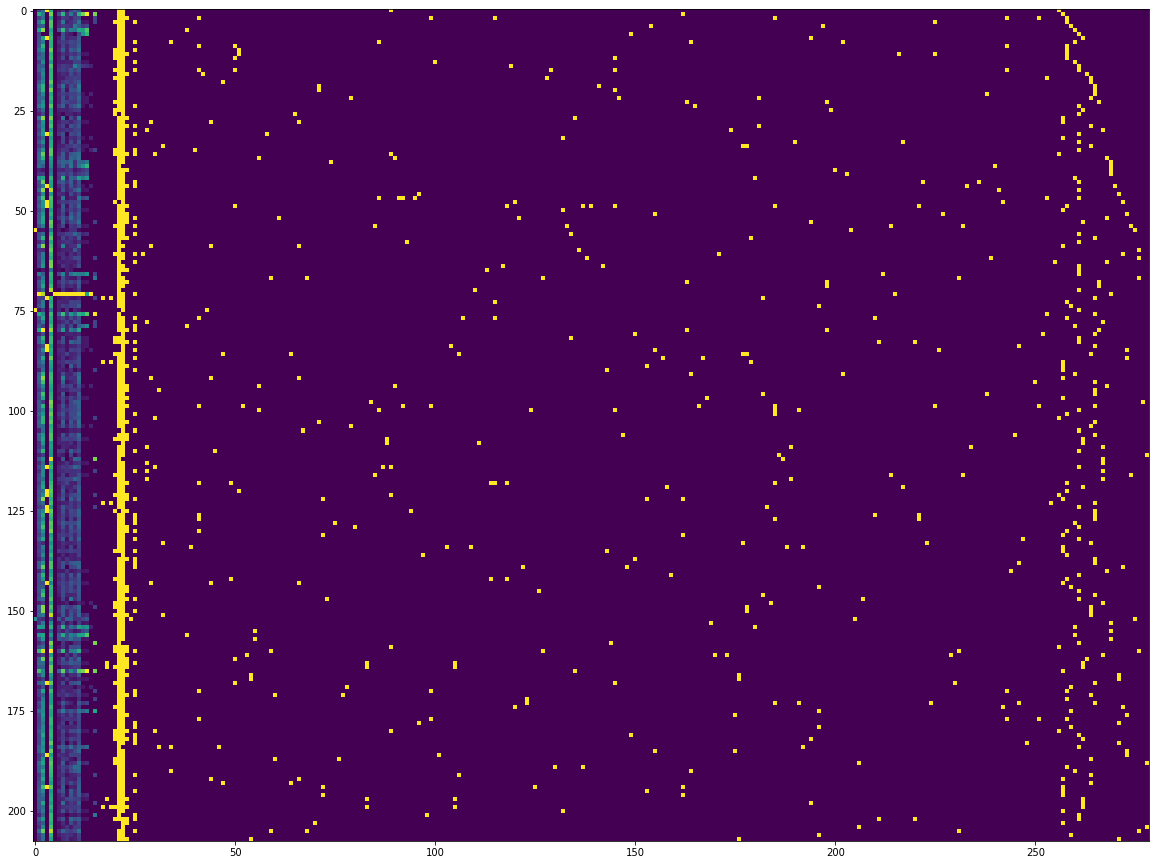

In [70]:
scaler_drugs = MinMaxScaler().fit(df_train_X_Drugs)
X_drug_features = scaler_drugs.transform(df_train_X_Drugs)
#Xtest_drug = scaler.transform(df_test_drug_new[X_columns])
plt.figure(figsize=(20,40))
plt.imshow(X_drug_features)
X_drug_features.shape

In [71]:
Matrix_drug_corr = np.corrcoef(X_drug_features)
print(np.corrcoef(X_drug_features[0,:],X_drug_features[1,:]))

[[1.         0.42778051]
 [0.42778051 1.        ]]


In [72]:
np.savetxt(path_to_save+"Matrix_drugs.csv", Matrix_drug_corr, delimiter=",")
Matrix_drug_corr

array([[1.        , 0.42778051, 0.31725519, ..., 0.41879327, 0.50409128,
        0.40763753],
       [0.42778051, 1.        , 0.3086322 , ..., 0.41507195, 0.46822864,
        0.36990667],
       [0.31725519, 0.3086322 , 1.        , ..., 0.28548114, 0.35360304,
        0.40663241],
       ...,
       [0.41879327, 0.41507195, 0.28548114, ..., 1.        , 0.46355803,
        0.37038302],
       [0.50409128, 0.46822864, 0.35360304, ..., 0.46355803, 1.        ,
        0.45638295],
       [0.40763753, 0.36990667, 0.40663241, ..., 0.37038302, 0.45638295,
        1.        ]])

In [73]:
df_train_X_Drugs

,MAX_CONC,molecular_weight,2bonds,3bonds,xlogp,formal_charge,surface_area,complexity,h_bond_donor_count,h_bond_acceptor_count,...,DNA replication,Hormone-related,Genome integrity,WNT signaling,JNK and p38 signaling,Chromatin other,Metabolism,Apoptosis regulation,Chromatin histone methylation,p53 pathway
0,2.0,393.4,8.0,1.0,3.3,0.0,74.7,525.0,1.0,7.0,...,0,0,0,0,0,0,0,0,0,0
1,0.1,914.2,9.0,0.0,6.0,0.0,195.0,1760.0,3.0,13.0,...,0,0,0,0,0,0,0,0,0,0
2,8.0,398.5,8.0,0.0,2.6,0.0,77.2,636.0,3.0,4.0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,641.6,13.0,0.0,5.0,0.0,111.0,1180.0,2.0,5.0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,475.6,7.0,0.0,4.8,0.0,114.0,644.0,3.0,5.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,10.0,390.4,7.0,0.0,3.2,0.0,60.9,510.0,1.0,8.0,...,0,0,0,0,0,0,0,0,0,0
204,10.0,328.4,10.0,0.0,4.6,0.0,52.7,387.0,3.0,3.0,...,0,0,0,0,0,0,0,0,0,1
205,5.0,573.7,15.0,0.0,7.8,0.0,132.0,963.0,4.0,6.0,...,0,0,0,0,0,0,0,1,0,0
206,10.0,352.4,8.0,0.0,3.7,0.0,87.6,479.0,3.0,5.0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
#Matrix_drug_corr.shape
#Matrix_cells_corr.shape

In [75]:
val_id

array([   0,   19,   21, ..., 9093, 9096, 9105])

In [76]:
len(IC50)

9108

In [77]:
val_id

array([   0,   19,   21, ..., 9093, 9096, 9105])

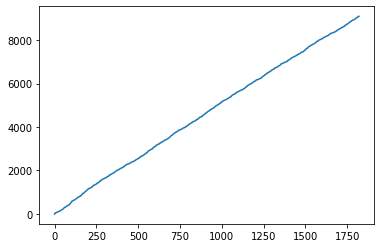

In [78]:
plt.plot(val_id)